# Inflow Mean Bulk Environmental Statistics

##### Supplementary code for Faletti et al. (2026): _Using Ensemble Sensitivity to Diagnose Environmental Modulation of Mesocyclone Intensity in the Warn-on-Forecast System_

### Reproduces Figs. 8, 11, 14, 17, S1-4

In [1]:
# Import basic libraries
import numpy as np
import matplotlib.pyplot as plt
import datetime
import xarray as xr
import datetime
import glob
import pandas as pd
import os

import haversine

# Import authored modules
import centered_response as cr
from wofunits import wofunits
from metpy.units import units
from wofs_colortables import cb_colors

import warnings
warnings.filterwarnings("ignore")

##  Manually set case, time, inflow domain specs, etc. for the desired plotting

In [2]:
################################ Set case/plotting specs  #######################################
    
# save plots?
save = False

    # select case
#case = '201905172100'
#case = '201905172200'
#case = '201905202030'
#case = '201905262000'
case = '201905282230'

    # set 6 state variables to compute
varlist = ['T2','MLCAPE','U10','V10','SHEAR_TOT1','SRH1_TRUE']

    # define response function variable (statevar only matters to select existing sens file; keep at T2 unless corresponding files don't exist)
statevar, respvar = 'T2','UH25-30MIN'

    # domain thresholding specs
inflow_region = 'if'
pthres = 0.05
ang_thres = 360
nf_dist = 40 # distance bound of near-inflow domain
ff_dist = 120 # distance bound of far-inflow domain
ang_bound1, ang_bound2 = 0, 230 # angular domain bounds relative to the storm motion
domain_lag = 0 # distance lag of domain origin to storm center in km

    # define common directories for file paths
sensdir = wofunits.paths['sens_path'] # sensitivity data path
respdir_sr = wofunits.paths['resp_path'] # response function path
wofsdir = wofunits.paths['wofs_path'] # WoFS data path
wofsdir_3d = wofunits.paths['wofs_path_3d'] # 3D WoFS data path
sm_path = wofunits.paths['sm_path'] # storm motion CSV path
outplot_path = wofunits.paths['outplot_path'] # plot save path

    # set list of axis labels
axlabels = ['a)','b)','c)','d)','e)','f)']


########### Automates formatting, etc. ####################

    # sets ground-relative response variable
if '30MIN' in respvar:
    respvar_gr = 'UH-30SWT25-WRF'
    respvar_gr_filestr = 'UH_30SWT25_WRF'
if '05MIN' in respvar:
    respvar_gr = None

    # define lead times by case
if case == '201905172200':
    lead_times = np.arange(105,-1,-15).tolist() 
if case == '201905202030':
    lead_times = np.arange(90,-1,-15).tolist()
if case == '201905262000':
    lead_times = np.arange(60,-1,-15).tolist()
if case == '201905282230':
    lead_times = np.arange(120,-1,-15).tolist()

## Plot Figs. 8, 11, 14, 17: 6-Panel Regression Scatters at 15-Minute Intervals (Final is 0-Minute Lead Time)

2019-05-28 23:00:00
2019-05-28 23:15:00
2019-05-28 23:30:00
2019-05-28 23:45:00
2019-05-29 00:00:00
2019-05-29 00:15:00
2019-05-29 00:30:00
2019-05-29 00:45:00
2019-05-29 01:00:00


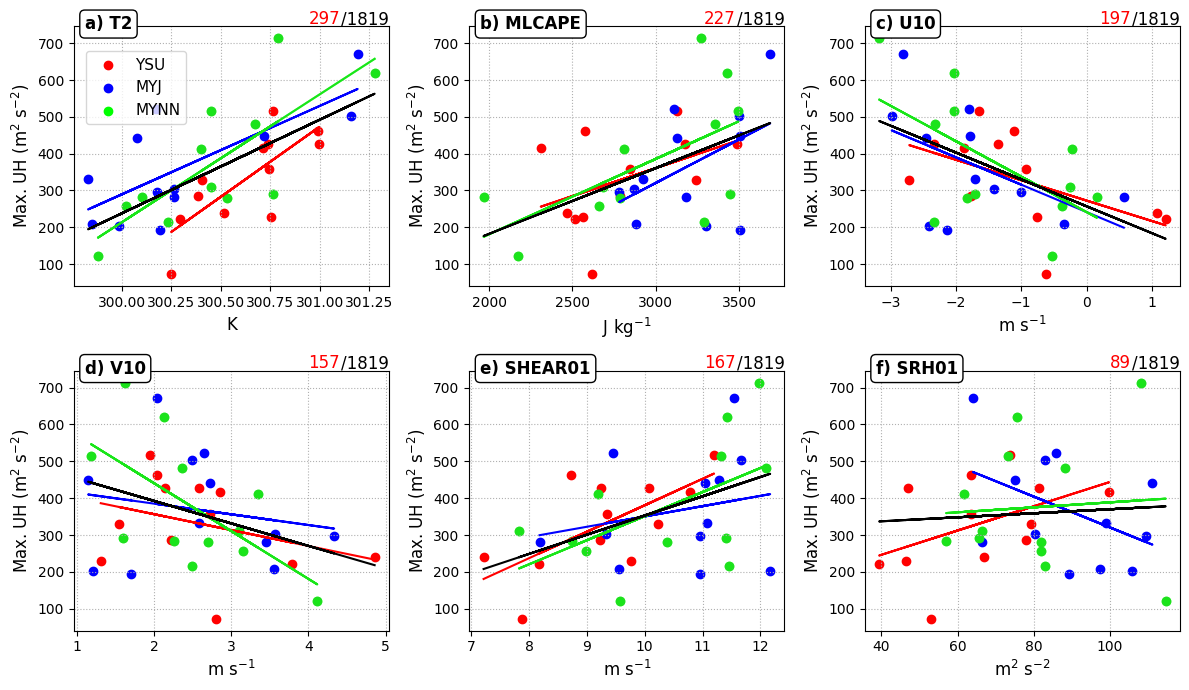

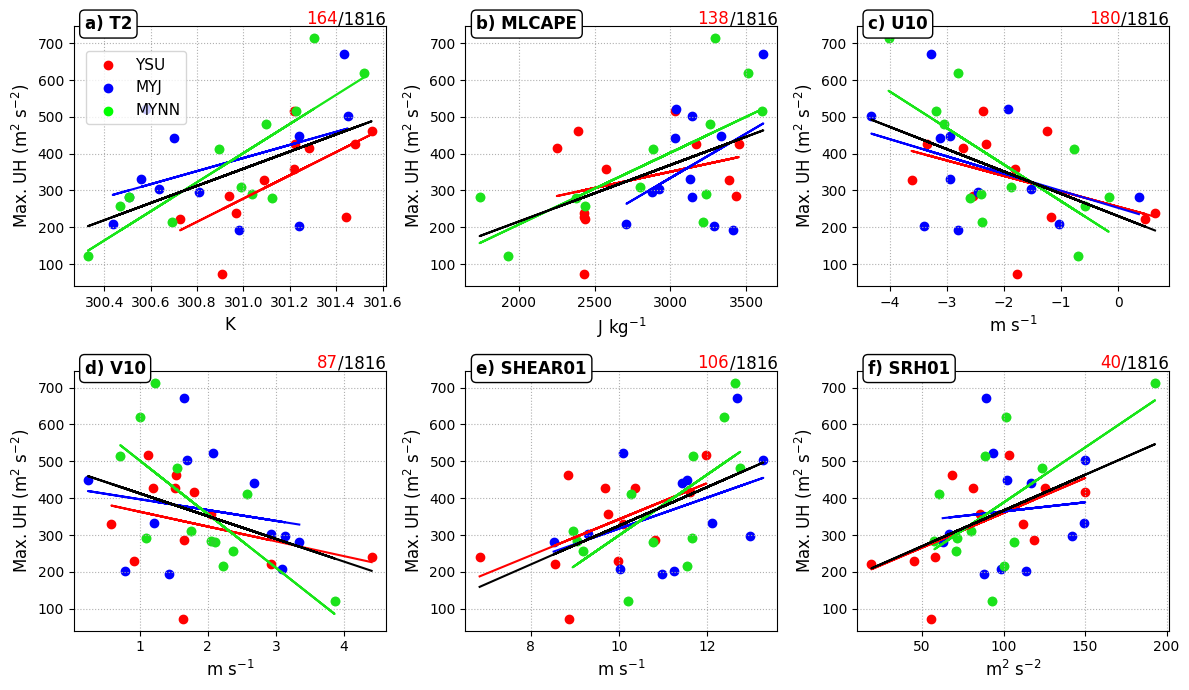

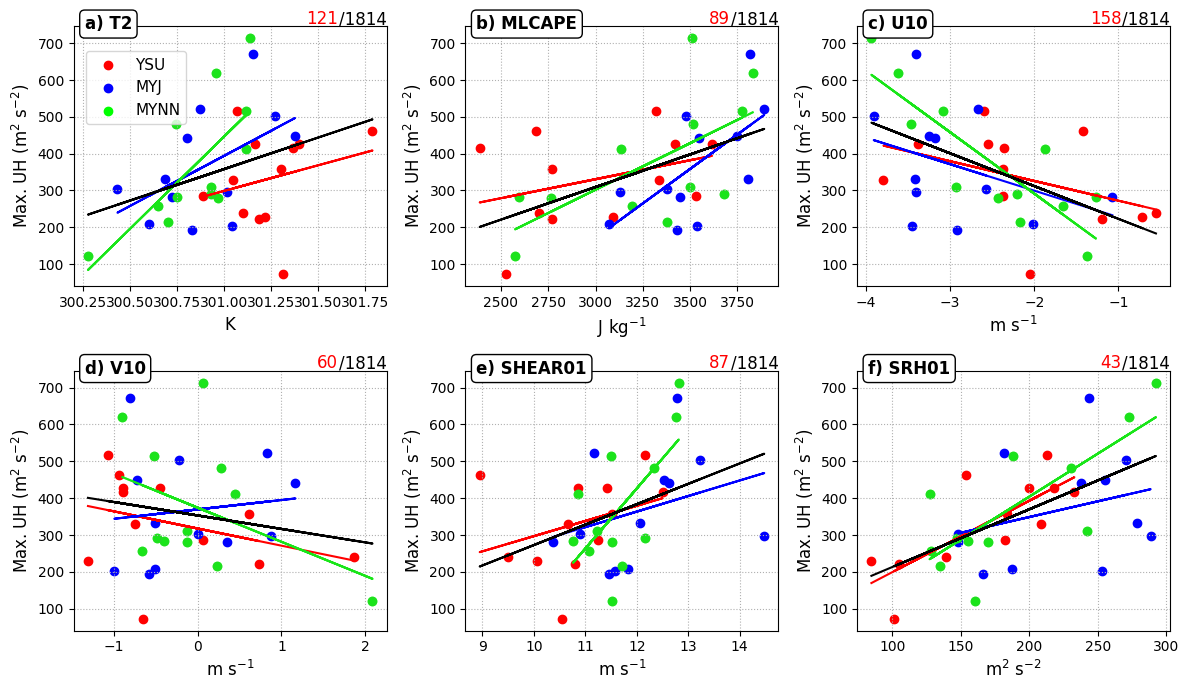

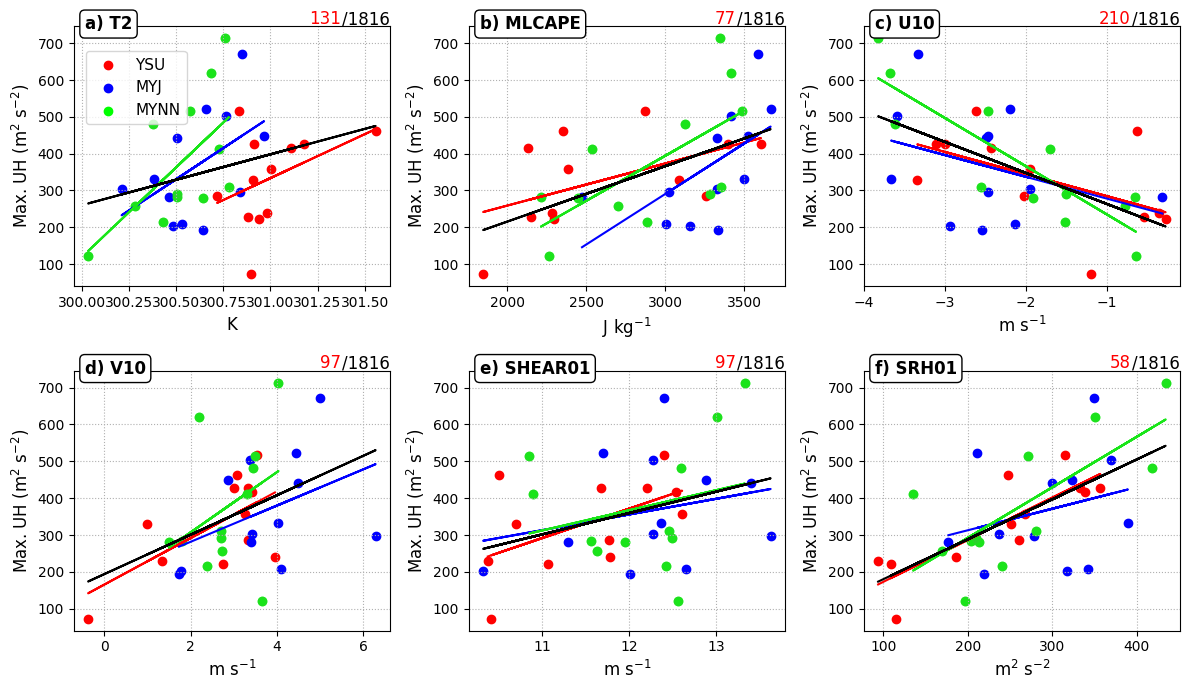

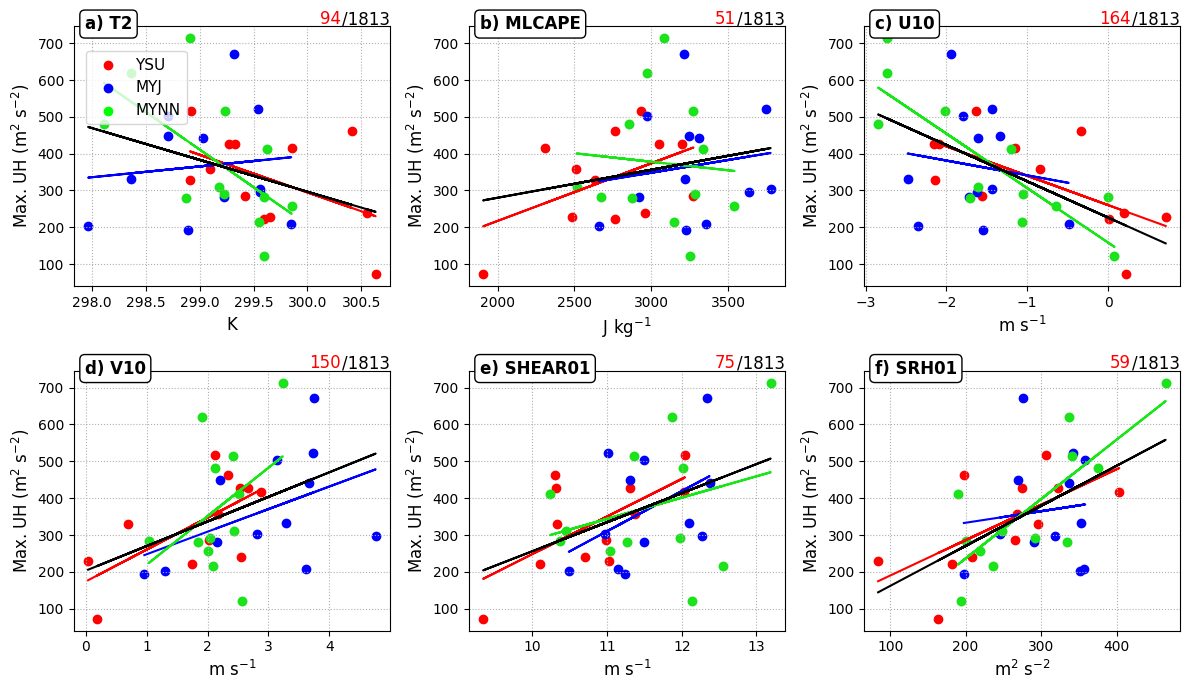

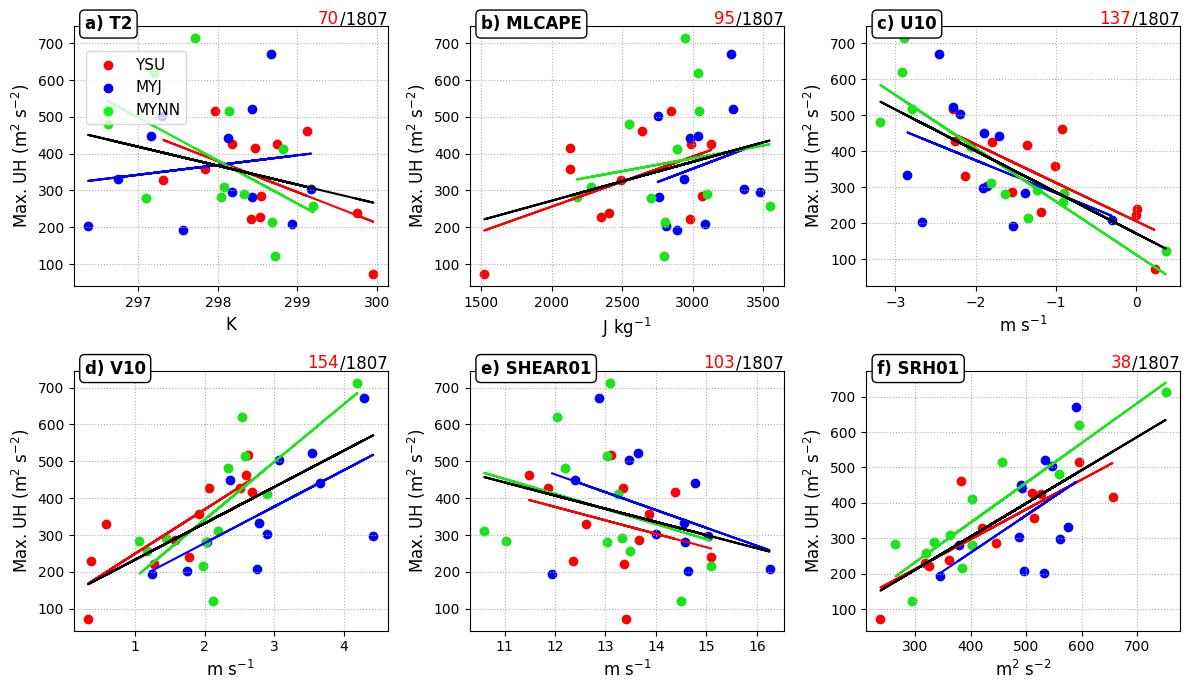

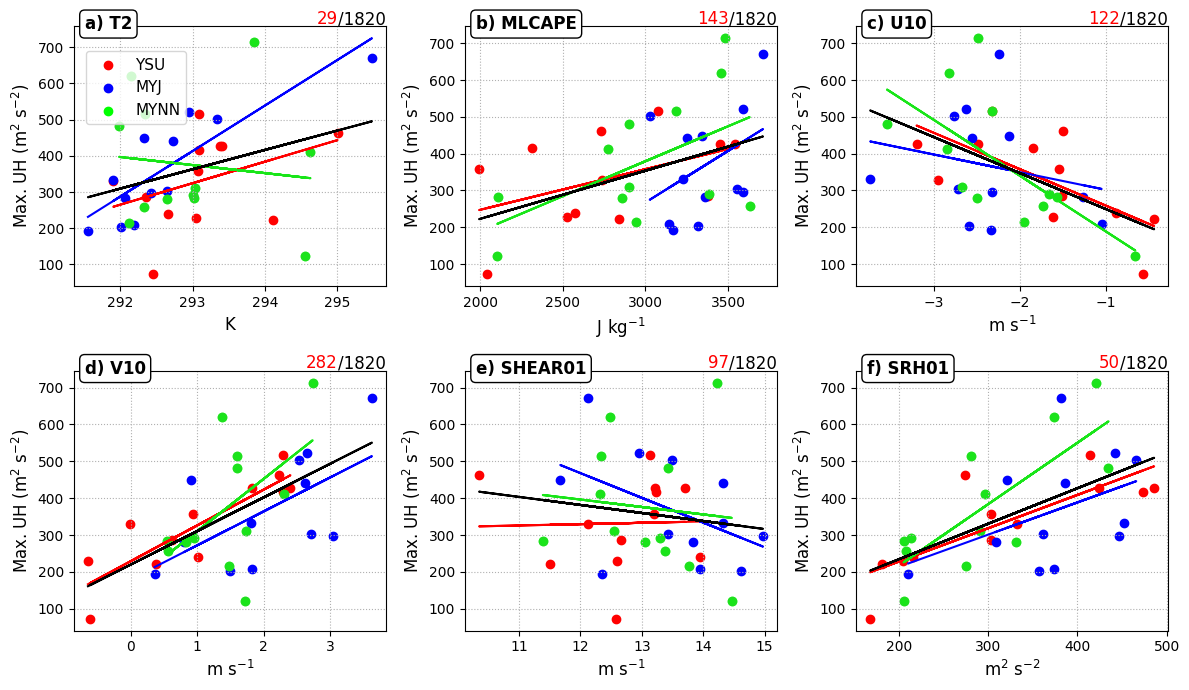

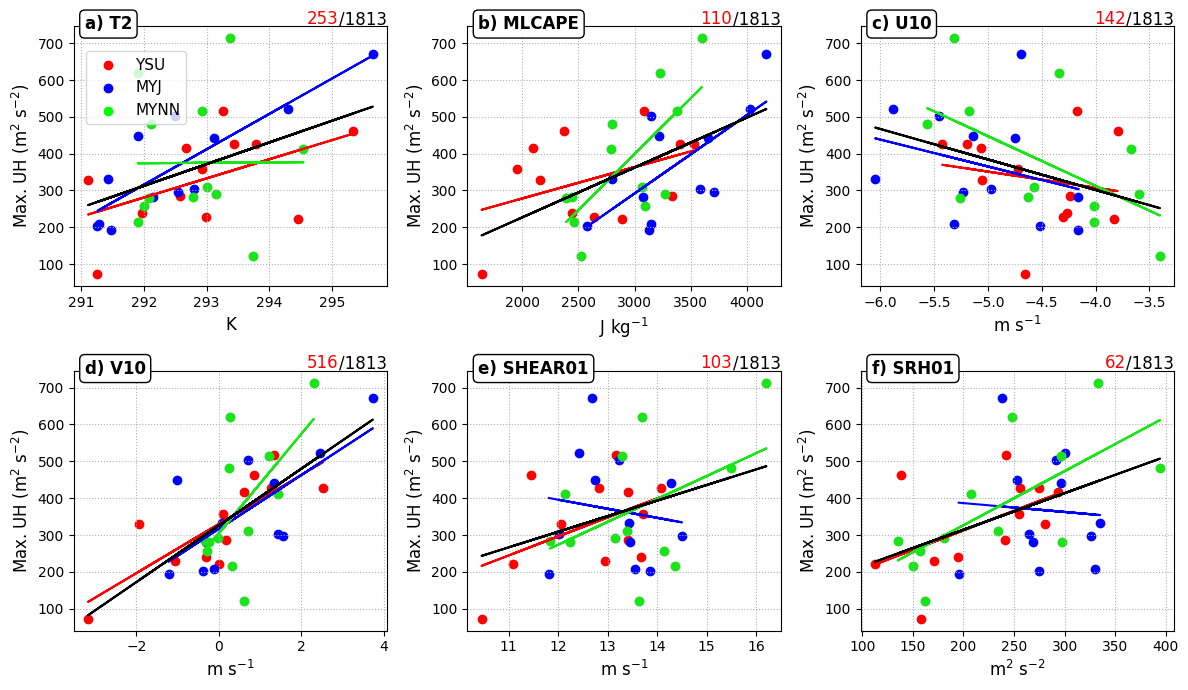

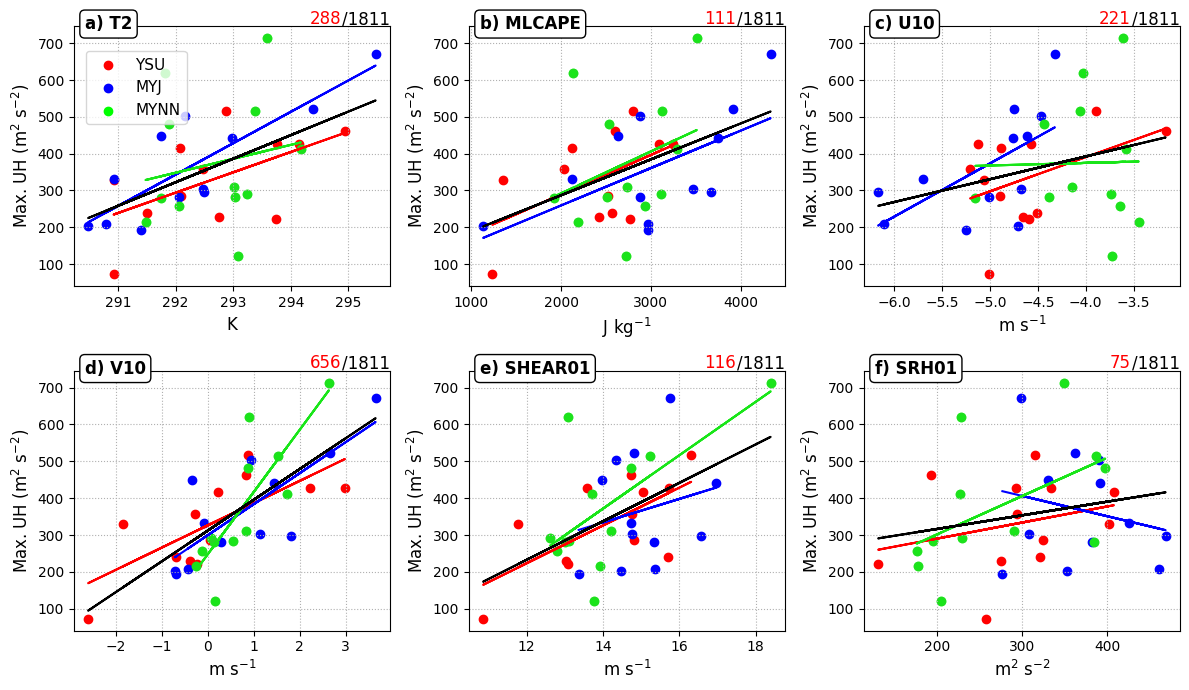

In [3]:
for lead_time in lead_times:

    ################################ Set case/plotting specs  #######################################
    
        # pull case specs
    wofs_casedir, file_latlons, file_coords, file_resp_coords, file_mrms_maxima, files_wofs, state_times, resptime = cr.case_sel(case)
    
    respvar_filestr = respvar.replace('-','_')
    
        # define state and response time as datetime objects
    resp_time = datetime.datetime.strptime(resptime, '%Y-%m-%d_%H_%M_%S')
    state_time = resp_time - datetime.timedelta(minutes=lead_time)
    
        # define file strings for given variables and time
    file_sens = f'{sensdir}/sens_center_{case}/stats_{respvar}_max_{str(resp_time.hour).zfill(2)}_{str(resp_time.minute).zfill(2)}_00_{statevar}_{str(state_time.hour).zfill(2)}_{str(state_time.minute).zfill(2)}_00.nc'
    respvar_filestr = respvar.replace('-','_')
    file_resp_sr = f'{respdir_sr}/resp_{respvar_filestr}_max_{resptime}.nc'
    
    file_ref = f'{wofsdir}/wofs_{case[:8]}_{case[8:]}/wofs_center_i{case}_v{state_time.year}{str(state_time.month).zfill(2)}{str(state_time.day).zfill(2)}{str(state_time.hour).zfill(2)}{str(state_time.minute).zfill(2)}.nc'
    
        # open netCDF files
    ds_sens = xr.open_dataset(file_sens)
    ds_ref = xr.open_dataset(file_ref)
    ds_resp_sr = xr.open_dataset(file_resp_sr)
    
        # define variables for overview plots
    sens = ds_sens.stdsens
    cref = np.where(np.nanmean(ds_ref.REFD_MAX, axis=0) < 10, np.nan, np.nanmean(ds_ref.REFD_MAX, axis=0))
    pstat = abs(ds_sens.pstat.values)
    
        # define response variables
    uhresp_sr = ds_resp_sr[respvar_filestr]
    
        # define PBL scheme indices
    ysu_idx, myj_idx, mynn_idx = wofunits.schemeidx['ysu'], wofunits.schemeidx['myj'], wofunits.schemeidx['mynn']
     
    
    ################################ Define storm-relative aspects  #######################################
    
        # define observed MRMS storm centers to center storm on plot
    df_center = cr.create_mrmscenter_df(file_coords, file_mrms_maxima)
    
        # string to 
    pdstr = f'{state_time.year}-{str(state_time.month).zfill(2)}-{str(state_time.day).zfill(2)} {str(state_time.hour).zfill(2)}:{str(state_time.minute).zfill(2)}:00'
    
        # open storm motion csv files
    sm_x = pd.read_csv(f'{sm_path}/{case}_motions_nx.csv', index_col='Member')
    sm_y = pd.read_csv(f'{sm_path}/{case}_motions_ny.csv', index_col='Member')

        # average storm motion components at chosen time
    sm_mean_x = np.nanmean(sm_x[:-1][pdstr].values)
    sm_mean_y = np.nanmean(sm_y[:-1][pdstr].values)
    
        # calculate angle of storm motion relative to positive x-axis
    storm_ang = cr.calc_storm_ang(sm_mean_x, sm_mean_y)
    
        # create 2D x and y storm-relative grids
    xmesh,ymesh = cr.xy_mesh(case, state_time)
    dist = (xmesh**2 + ymesh**2)**0.5 # convert to 2D meshgrid
    
        # calculate storm-relative angle of each gridpoint 
    ang_tot = cr.calc_ang_tot(xmesh,ymesh,storm_ang=storm_ang)
    
        # calculate angle difference between SR gridpoint position and SR 
    ang_diff = cr.srw_ang_diff(case, state_time)    
    
    
    print(state_time)
    
    ####### Plot storm-relative sensitivity scatter plot #########
    
    fig3, ax = plt.subplots(2,3, figsize=(12,7))
    ax = ax.flatten()
    
    for i in range(len(varlist)):
        statevar_str = varlist[i].replace('_','-')
        file = f'{sensdir}/sens_center_{case}/stats_{respvar}_max_{resptime[11:]}_{statevar_str}_{str(state_time.hour).zfill(2)}_{str(state_time.minute).zfill(2)}_00.nc'
        ds_sens = xr.open_dataset(file)
        pstat = abs(ds_sens.pstat.values)
        
        if inflow_region == 'ff':
            sensvar = np.where( (dist < nf_dist) | (dist > ff_dist) | (ang_tot > ang_bound1) & (ang_tot < ang_bound2) | (ang_diff > ang_thres) | (pstat > pthres), np.nan, ds_ref[varlist[i]].values)
        elif inflow_region == 'nf':
            sensvar = np.where(  (dist > nf_dist) | (ang_tot > ang_bound1) & (ang_tot < ang_bound2) | (ang_diff > ang_thres) | (pstat > pthres), np.nan, ds_ref[varlist[i]].values)
        elif inflow_region == 'if':
            sensvar = np.where( (dist > ff_dist) | (ang_tot > ang_bound1) & (ang_tot < ang_bound2)  | (ang_diff > ang_thres) | (pstat > pthres), np.nan, ds_ref[varlist[i]].values)
        
            # count fraction of grid points within domain with statistical significance
        scatter_count = np.count_nonzero(~np.isnan(sensvar[0,0]))
        domain_count = np.count_nonzero(~np.isnan(np.where( (dist > ff_dist) | (ang_tot > ang_bound1) & (ang_tot < ang_bound2)  | (ang_diff > ang_thres), np.nan, ds_ref[varlist[i]].values[0,0])))
        
        state_avg = np.nanmean(sensvar, axis=(1,2,3))
        
        ax[i].scatter(state_avg[ysu_idx], uhresp_sr[ysu_idx], color='r')
        ax[i].scatter(state_avg[myj_idx], uhresp_sr[myj_idx], color='b')
        ax[i].scatter(state_avg[mynn_idx], uhresp_sr[mynn_idx], color='lime', alpha=1)
        ax[i].scatter(state_avg[mynn_idx], uhresp_sr[mynn_idx], color='limegreen', alpha=0.5)
        
        try:
            m_ysu,b_ysu=np.polyfit(state_avg[ysu_idx], uhresp_sr[ysu_idx],1)
            m_myj,b_myj=np.polyfit(state_avg[myj_idx], uhresp_sr[myj_idx],1)
            m_mynn,b_mynn=np.polyfit(state_avg[mynn_idx], uhresp_sr[mynn_idx],1)
            m_tot,b_tot=np.polyfit(state_avg, uhresp_sr,1)
        except:
            pass
        
        ax[i].plot(state_avg[ysu_idx], m_ysu*state_avg[ysu_idx] + b_ysu, color='r')
        ax[i].plot(state_avg[myj_idx], m_myj*state_avg[myj_idx] + b_myj, color='b')
        ax[i].plot(state_avg[mynn_idx], m_mynn*state_avg[mynn_idx] + b_mynn, color='lime', alpha=1)
        ax[i].plot(state_avg[mynn_idx], m_mynn*state_avg[mynn_idx] + b_mynn, color='limegreen', alpha=0.5)
        ax[i].plot(state_avg, m_tot*state_avg + b_tot, c='k')

        ax[i].text(0.845, 1.01, f'{scatter_count}', transform=ax[i].transAxes, 
                    size=12, color='r', horizontalalignment='right')
        ax[i].text(1, 1.01, f'/{domain_count}', transform=ax[i].transAxes, 
                    size=12, color='k', horizontalalignment='right')
        
        if '_TOT' in varlist[i]:
            #ax[i].set_title(f'{varlist[i][0:5]}0{varlist[i][-1]}', weight='bold', size=12)
            ax[i].text(0.035, 0.99,f'{axlabels[i]} {varlist[i][0:5]}0{varlist[i][-1]}', color='k',
                bbox=dict(facecolor='w', boxstyle='round', edgecolor='k'), transform=ax[i].transAxes, 
                size=12, weight='bold')
        elif '_TRUE' in varlist[i]:
            ax[i].text(0.035, 0.99,f'{axlabels[i]} {varlist[i][0:3]}0{varlist[i][3]}', color='k',
                bbox=dict(facecolor='w', boxstyle='round', edgecolor='k'), transform=ax[i].transAxes, 
                size=12, weight='bold')
        else:
            #ax[i].set_title(varlist[i], weight='bold', size=12)
            ax[i].text(0.035, 0.99, f'{axlabels[i]} {varlist[i]}', color='k',
                bbox=dict(facecolor='w', boxstyle='round', edgecolor='k'), transform=ax[i].transAxes, 
                size=12, weight='bold')
        ax[i].set_xlabel(wofunits.labels[varlist[i]], size=12)
        ax[i].set_ylabel(f'Max. UH ({wofunits.labels[respvar]})', size=12)
        
        #ax[i].text(0.035, 0.97, axlabels[i], color='k',
        #    bbox=dict(facecolor='w', boxstyle='round', edgecolor='k'), transform=ax[i].transAxes, 
        #    size=14, weight='bold')
    
        ax[i].grid(ls=':')

        if i == 0:
            ax[i].legend(['YSU', 'MYJ', 'MYNN'], loc=(0.04, 0.625), fontsize=11)
        
        
    plt.tight_layout()
    
    if save == True:
        savedir = f'{outplot_path}/sr_scatters_new/{case}'
        if not os.path.exists(savedir):
            os.makedirs(savedir)
        
        plt.savefig(f'{savedir}/{lead_time}min_leadtime.png',dpi=300, bbox_inches='tight', facecolor='w')

## Plot Figs. S1-4: Inflow Mean Boxplots by Tercile at Selected Lead Time 

In [4]:
# set lead time (minutes) and calculate corresponding state time
lead_time = 30
state_time = resp_time - datetime.timedelta(minutes=lead_time)

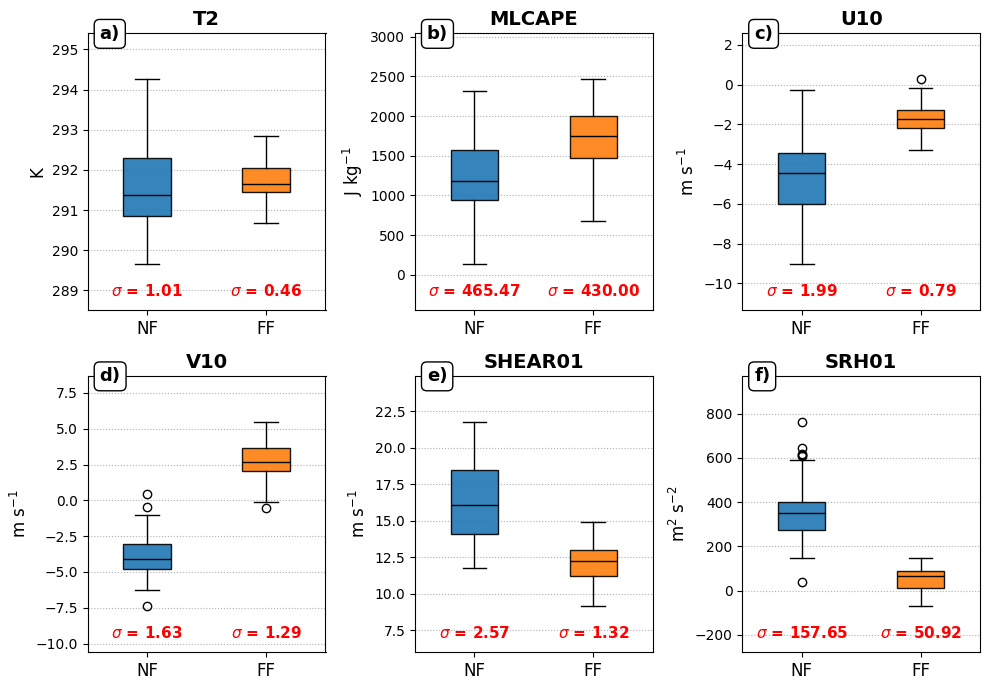

In [5]:

####### Plot inflow boxplot by tercile #########

fig3, ax = plt.subplots(2,3, figsize=(10,7))
ax = ax.flatten()

for i in range(len(varlist)):
    statevar_str = varlist[i].replace('_','-')
    file = f'{sensdir}/sens_center_{case}/stats_{respvar}_max_{resptime[11:]}_{statevar_str}_{str(state_time.hour).zfill(2)}_{str(state_time.minute).zfill(2)}_00.nc'
    ds_sens = xr.open_dataset(file)
    pstat = abs(ds_sens.pstat.values)

    data = []
    for domain in ['nf','ff']:
        if domain == 'ff':
            sensvar = np.where( (dist < nf_dist) | (dist > ff_dist) | (ang_tot > ang_bound1) & (ang_tot < ang_bound2) | (ang_diff > ang_thres) | (pstat > pthres), np.nan, ds_ref[varlist[i]].values)
        elif domain == 'nf':
            sensvar = np.where(  (dist > nf_dist) | (ang_tot > ang_bound1) & (ang_tot < ang_bound2) | (ang_diff > ang_thres) | (pstat > pthres), np.nan, ds_ref[varlist[i]].values)
        
        data.append(np.nanmean(sensvar, axis=(1,2,3)))
    
        # count fraction of grid points within domain with statistical significance
    scatter_count = np.count_nonzero(~np.isnan(sensvar[0,0]))
    domain_count = np.count_nonzero(~np.isnan(np.where( (dist > ff_dist) | (ang_tot > ang_bound1) & (ang_tot < ang_bound2)  | (ang_diff > ang_thres), np.nan, ds_ref[varlist[i]].values[0,0])))
    
    ax[i].boxplot(data[0], positions=[1], widths=0.4, patch_artist=True,
                  medianprops={"color": "k", "linewidth": 1},
                  boxprops={"facecolor": "tab:blue", "edgecolor": "k", "linewidth": 1, "alpha":0.9})
    ax[i].boxplot(data[1], positions=[2], widths=0.4, patch_artist=True,
                  medianprops={"color": "k", "linewidth": 1},
                  boxprops={"facecolor": "tab:orange", "edgecolor": "k", "linewidth": 1, "alpha":0.9})  
    
    #ax[i].scatter(state_avg[myj_idx], uhresp_sr[myj_idx], color='b')
    #ax[i].scatter(state_avg[mynn_idx], uhresp_sr[mynn_idx], color='lime', alpha=1)
    #ax[i].scatter(state_avg[mynn_idx], uhresp_sr[mynn_idx], color='limegreen', alpha=0.5)
    
    if '_TOT' in varlist[i]:
        #ax[i].set_title(f'{varlist[i][0:5]}0{varlist[i][-1]}', weight='bold', size=12)
        ax[i].text(0.05, 0.98,f'{axlabels[i]}', color='k',
            bbox=dict(facecolor='w', boxstyle='round', edgecolor='k'), transform=ax[i].transAxes, 
            size=13, weight='bold')
        ax[i].set_title(f'{varlist[i][0:5]}0{varlist[i][-1]}', weight='bold', size=14)
        
    elif '_TRUE' in varlist[i]:
        ax[i].text(0.05, 0.98,f'{axlabels[i]}', color='k',
            bbox=dict(facecolor='w', boxstyle='round', edgecolor='k'), transform=ax[i].transAxes, 
            size=13, weight='bold')
        ax[i].set_title(f'{varlist[i][0:3]}0{varlist[i][3]}', weight='bold', size=14)
    else:
        #ax[i].set_title(varlist[i], weight='bold', size=12)
        ax[i].text(0.05, 0.98, f'{axlabels[i]}', color='k',
            bbox=dict(facecolor='w', boxstyle='round', edgecolor='k'), transform=ax[i].transAxes, 
            size=13, weight='bold')
        ax[i].set_title(f'{varlist[i]}', weight='bold', size=14)

    ax[i].text(0.25, 0.05, '$\sigma$ = ' + '{0:.2f}'.format(np.nanstd(data[0])), color='r', transform=ax[i].transAxes, 
            size=11, weight='bold', horizontalalignment='center')
    ax[i].text(0.75, 0.05, '$\sigma$ = ' + '{0:.2f}'.format(np.nanstd(data[1])), color='r', transform=ax[i].transAxes, 
            size=11, weight='bold', horizontalalignment='center')
    
    ax[i].set_xticklabels(['NF', 'FF'], size=12)
    #ax[i].set_xlabel(wofunits.labels[varlist[i]], size=12)
    ax[i].set_ylabel(f'{wofunits.labels[varlist[i]]}', size=12)
    
    #ax[i].text(0.035, 0.97, axlabels[i], color='k',
    #    bbox=dict(facecolor='w', boxstyle='round', edgecolor='k'), transform=ax[i].transAxes, 
    #    size=14, weight='bold')

    ax[i].grid(ls=':', axis='y')
    ax[i].margins(0.05,0.25)
    
plt.tight_layout()

if save == True:
    plt.savefig(f'{outplot_path}/boxplots_{case}.png',dpi=300, bbox_inches='tight', facecolor='w')

####### Plot ground-relative sensitivity scatter plot #########

file_resp_gr = f'{sensdir}/sens_{case}/resp_{respvar_gr_filestr}_max_{resptime}.nc'
ds_resp_gr = xr.open_dataset(file_resp_gr)
uhresp_gr = ds_resp_gr[respvar_gr_filestr]

varlist = ['T2','TD2','MLCAPE','PBLH','U10','V10','SHEAR_TOT1','SHEAR_TOT6']

fig4, ax = plt.subplots(2,4, figsize=(16,7))
ax = ax.flatten()

uhresp_gr = ds_resp_gr[respvar_gr_filestr]

for i in range(len(varlist)):
    statevar_str = varlist[i].replace('_','-')
    file_sens_gr = f'{sensdir}/sens_{case}/stats_{respvar_gr}_max_{resptime[11:]}_{statevar_str}_{str(state_time.hour).zfill(2)}_{str(state_time.minute).zfill(2)}_00.nc'
    file_state_gr = f'{wofsdir}/wofs_{case[:8]}_{case[8:]}/wofs_i{case}_v{state_time.year}{str(state_time.month).zfill(2)}{str(state_time.day).zfill(2)}{str(state_time.hour).zfill(2)}{str(state_time.minute).zfill(2)}.nc'
    
    ds_sens_gr = xr.open_dataset(file_sens_gr)
    pstat = abs(ds_sens_gr.pstat.values)
    
    ds_state_gr = xr.open_dataset(file_state_gr)
    
    sensvar = ds_state_gr[varlist[i]].values
    sensvar = np.where(ds_state_gr.XLONG[0,0] < ds_resp_gr.attrs['RF_CENTER_LON'] + ds_resp_gr.attrs['RF_X_LEFT'], np.nan, sensvar) # wrong center longitude given to sensitivity script, oops
    sensvar = np.where(ds_state_gr.XLONG[0,0] > ds_resp_gr.attrs['RF_CENTER_LON'] + ds_resp_gr.attrs['RF_X_RIGHT'], np.nan, sensvar)
    sensvar = np.where(ds_state_gr.XLAT[0,0] < ds_resp_gr.attrs['RF_CENTER_LAT'] + ds_resp_gr.attrs['RF_Y_BOTTOM'], np.nan, sensvar)
    sensvar = np.where(ds_state_gr.XLAT[0,0] > ds_resp_gr.attrs['RF_CENTER_LAT'] + ds_resp_gr.attrs['RF_Y_TOP'], np.nan, sensvar)
    sensvar = np.where(pstat > 0.05, np.nan, sensvar)
    
    state_avg = np.nanmean(sensvar, axis=(1,2,3))
    
    ax[i].scatter(state_avg[ysu_idx], uhresp_gr[ysu_idx], c='r')
    ax[i].scatter(state_avg[myj_idx], uhresp_gr[myj_idx], c='b')
    ax[i].scatter(state_avg[mynn_idx], uhresp_gr[mynn_idx], c='g')
    
    m_ysu,b_ysu=np.polyfit(state_avg[ysu_idx], uhresp_gr[ysu_idx],1)
    m_myj,b_myj=np.polyfit(state_avg[myj_idx], uhresp_gr[myj_idx],1)
    m_mynn,b_mynn=np.polyfit(state_avg[mynn_idx], uhresp_gr[mynn_idx],1)
    m_tot,b_tot=np.polyfit(state_avg, uhresp_gr,1)
    
    ax[i].plot(state_avg[ysu_idx], m_ysu*state_avg[ysu_idx] + b_ysu, c='r')
    ax[i].plot(state_avg[myj_idx], m_myj*state_avg[myj_idx] + b_myj, c='b')
    ax[i].plot(state_avg[mynn_idx], m_mynn*state_avg[mynn_idx] + b_mynn, c='g')
    ax[i].plot(state_avg, m_tot*state_avg + b_tot, c='k')
    
    ax[i].set_title(varlist[i], weight='bold', size=12)
    ax[i].set_xlabel(wofunits.labels[varlist[i]], size=12)
    ax[i].set_ylabel(f'Max. UH ({wofunits.labels[respvar]})', size=12)
    
    ax[i].grid(ls=':')
    
plt.tight_layout()

if save == True:
    plt.savefig('gr_regressions.jpg', dpi=300, bbox_inches='tight', facecolor='w')